In [22]:
! kaggle datasets download -d earth16/libri-speech-noise-dataset

Dataset URL: https://www.kaggle.com/datasets/earth16/libri-speech-noise-dataset
License(s): DbCL-1.0
100% 6.03G/6.03G [04:33<00:00, 25.1MB/s]
100% 6.03G/6.03G [04:33<00:00, 23.6MB/s]


In [23]:
!unzip "/content/libri-speech-noise-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0031.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0040.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0043.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0047.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0049.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0050.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0053.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0057.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0062.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0069.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0080.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0084.npy  
  inflating: LibriNoise_Train_Test_NPY/mat_ytrain/2910-131096-0089.npy  


In [24]:
! mkdir train
! mkdir test
! mkdir y_train
! mkdir y_test

In [25]:
!rm -r /content/LibriNoise_Train_Test_NPY
!rm -r /content/NoiseTest.pptx
!rm -r /content/NoiseTest_SNR.pptx
!rm -r /content/epoc-27-results.xltx
!rm -r /content/model.h5.png
!rm -r /content/samples.7z
!rm -r /content/results.7z
!rm -r /content/noisesB.7z
!rm -r /content/ModelArchitecture.txt
!rm -r /content/libri-speech-noise-dataset.zip
!rm -r /content/BWAVN.7z

In [26]:
from google.colab import output
!7z x "/content/train.7z"
output.clear()
!7z x "/content/test.7z"
output.clear()
!7z x "/content/y_train.7z"
output.clear()
!7z x "/content/y_test.7z"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 36121398 bytes (35 MiB)

Extracting archive: /content/y_test.7z
--
Path = /content/y_test.7z
Type = 7z
Physical Size = 36121398
Headers Size = 2184
Method = Delta LZMA2:24
Solid = +
Blocks = 1

  0%      7% 7 - y_test/125-121124-0076.wav                                    14% 15 - y_test/198-126831-0000.wav                                     23% 24 - y_test/2182-181173-0033.wav                                      30% 33 - y_test/2952-407-0002.wav

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import librosa
import os
import heapq
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas
from tensorflow.keras.models import model_from_json
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import soundfile as sf


In [28]:
def nb_audios(file_path):
  print(f'number of audios in "{file_path}" are ' + str(len(os.listdir(file_path))))

In [29]:
nb_audios('/content/y_train')
nb_audios('/content/train')

number of audios in "/content/y_train" are 7000
number of audios in "/content/train" are 7000


In [30]:
def keep_n_files(directory, n):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    files.sort()
    num_files_to_delete = len(files) - n

    for i in range(num_files_to_delete):
        os.remove(os.path.join(directory, files[i]))

In [31]:
no_of_files = 100

In [32]:
keep_n_files("/content/train", no_of_files)
keep_n_files('/content/y_train', no_of_files)

In [33]:
nb_audios('/content/y_train')
nb_audios('/content/train')

number of audios in "/content/y_train" are 100
number of audios in "/content/train" are 100


# Steps of Preprocessing Audio Files
1. Split audios of frame length which is 8064
2. Convert the list of frames into 2D array or in matrix form
3. Convert audio frames to spectrograms using STFT
4. Convert spectrograms to matrix spectrograms
5. Normalize the matrix values between -1 and 1 for tanh activation function




## Splitting Audios into Frames

We will be splitting audios into small frames of same length. It is important as Convolutional Neural Network (CNN) requies contsistant shape and size of inputs. We have frames of 8064 length and the hop length will be of 8064. The hop length and frame length are equal which means no overlapping. The following function split_Audios() is used to split the audios.

In [34]:
def split_Audios(dir_path, frame_length, hop_length):
  frame_list = []
  print(f'number of audios in "{dir_path}" are ' + str(len(os.listdir(dir_path))))
  for audio in os.listdir(dir_path):
    if audio.split('.')[-1] != 'wav':
      continue
    audio_path = os.path.join(dir_path, audio)
    y, sr = librosa.load(audio_path, sr=sample_rate)

    for i in range(0, y.shape[0] - frame_length + 1, hop_length):
      frame_list.append(y[i : i + frame_length])

  print(f'number of frames in "{dir_path}" are ' + str(len(frame_list)))
  frame_list = np.vstack(frame_list)
  print(frame_list.shape)
  return frame_list


In [35]:
sample_rate = 8000
hop_length_fft = 63
frame_length = 8064
hop_length = 8064

## Create Spectrograms

We will be making spectrograms of all the frames. We will use STFT function from librosa library. We will also create a function to plot these spectrograms. We will use n_fft of 255 size and hop_size of 63. The fuction is defined below as spectrogram(). It returns magniture and phase of the audio. We also converted mangnitude to DB as we need to represent spectrograms in matrix form.

In [36]:
def plot_spectrogram(spectrogram, sr, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

In [37]:
def spectrogram(frame_list, sr=8000, save=False, plot=False):
    spectrograms = []
    phases = []

    plt.figure(figsize=(10, len(frame_list) * 3))  # Adjust figure size for multiple spectrograms

    for i, frame in enumerate(frame_list):
        # Compute STFT
        D = librosa.stft(frame, n_fft=255, hop_length=63) # 255 and 63 as with 256 and 64 the shape will be 129,127. We need 128,128
        print("D.shape in spec")
        print(D.shape)
        magnitude, phase = librosa.magphase(D)
        print('magnitude and ohase')
        print(magnitude.shape, phase.shape)
        magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)  # Convert to dB scale

        spectrograms.append(magnitude_db)
        phases.append(phase)


        if plot:
          # Plot each spectrogram
          plt.subplot(len(frame_list), 1, i + 1)
          librosa.display.specshow(magnitude_db, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
          plt.colorbar(format='%+2.0f dB')
          plt.title(f'Spectrogram {i+1}')

          # Save if needed
          if save:
              plt.savefig(f'spectrogram_{i+1}.png', bbox_inches='tight', pad_inches=0)

    plt.tight_layout()
    plt.show()

    return spectrograms, phases  # Return all spectrograms & phases


## Normalizing the Spectrogram

Normalizing or scalling is very important for the training of models. We used mix,max normalization and we normalized it in range [-1,1].

In [38]:
def normalize_spectrogram(spectrograms, print=False):
    """Normalize spectrogram to range [-1, 1] (for tanh activation)."""
    if isinstance(spectrograms, list):
        normalized_list = []
        for i, spec in enumerate(spectrograms):
            norm_spec = 2 * (spec - spec.min()) / (spec.max() - spec.min()) - 1
            normalized_list.append(norm_spec)
            if print:
              print(f"Spectrogram {i+1}: min={norm_spec.min()}, max={norm_spec.max()}")

        return normalized_list

    # Normalize a single spectrogram
    return 2 * (spectrograms - spectrograms.min()) / (spectrograms.max() - spectrograms.min()) - 1


In [39]:
nb_audios('/content/train')
nb_audios('/content/y_train')

number of audios in "/content/train" are 100
number of audios in "/content/y_train" are 100


In [40]:
train_dir = '/content/train'
test_dir = '/content/test' # not using
y_train_dir = '/content/y_train'
y_test_dir = '/content/y_test' # not using

Calling all the above functions to complete the preprocessing of audio files. The function is defined as organizing_dataset()

In [41]:
def organizing_dataset(X_dir, Y_dir):

  noisy_frame_list = []
  clean_frame_list = []
  mag_List = []
  pha_List = []

  noisy_frame_list = split_Audios(X_dir, frame_length, hop_length)
  mag_n, pha_n = spectrogram(noisy_frame_list)

  mag_n = normalize_spectrogram(mag_n)

  clean_list = split_Audios(Y_dir, frame_length, hop_length)
  mag_c, pha_c = spectrogram(clean_list)

  mag_c = normalize_spectrogram(mag_c)
  np.save('clean_mag', mag_c)
  np.save('noisy_mag', mag_n)

In [42]:
organizing_dataset(train_dir,y_train_dir)

number of audios in "/content/train" are 100
number of frames in "/content/train" are 1249
(1249, 8064)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)

<Figure size 1000x374700 with 0 Axes>

number of audios in "/content/y_train" are 100
number of frames in "/content/y_train" are 1249
(1249, 8064)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 

<Figure size 1000x374700 with 0 Axes>

In [43]:
noisy_mag_db = np.load('/content/noisy_mag.npy')
print(np.shape(noisy_mag_db))

(1249, 128, 128)


In [44]:
clean_mag_db = np.load('/content/clean_mag.npy')
print(np.shape(clean_mag_db))

(1249, 128, 128)


In [45]:
def input_reshape(x):
  x = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
  return x

# Defining CNN Model

U-Net is a deep learning model. It has a U-shaped structure with three parts: an encoder, a bottleneck, and a decoder. The encoder extracts important features from the input using convolutional layers and reduces the size with max pooling. The bottleneck acts as a bridge, capturing deeper features. The decoder then reconstructs the output using transposed convolutions, with skip connections helping to retain details lost during encoding. This structure makes U-Net great for processing spectrograms, as it learns both fine and broad patterns in speech while preserving important details. Its ability to work well with limited data makes it a strong choice for noise reduction in audio processing.

In [46]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
# print(tf.__version__)

#Unet network
def unet(input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['mae'])

    return model

In [47]:
def plot_loss(history):
    """
    Plot training and validation loss on a log scale.

    Parameters:
    history : Keras History object
        The history returned from model.fit(), containing loss values.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.yscale('log')  # Log scale for better visualization
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training Model

The model is being trained for 20 epochs.

In [48]:
def training_model(epochs, batch_size):
  clean_audio = np.load('clean_mag.npy')
  noisy_audio = np.load('noisy_mag.npy')

  clean_audio = input_reshape(clean_audio)
  noisy_audio = input_reshape(noisy_audio)

  X_train, X_test, y_train, y_test = train_test_split(noisy_audio, clean_audio, test_size=0.10, random_state=42)

  model = unet()
  checkpoint = ModelCheckpoint('model_unet_best.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')
  model.summary()

  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))
  model_in_json = model.to_json()

  with open('model_unet.json','w') as json_file:
      json_file.write(model_in_json)

  plot_loss(history)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ leaky_re_lu_5[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 1,941,093 (7.40 MB)

 Trainable params: 1,941,093 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2014 - mae: 0.3455
Epoch 1: loss improved from inf to 0.14459, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - loss: 0.2010 - mae: 0.3452 - val_loss: 0.1285 - val_mae: 0.2947
Epoch 2/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1207 - mae: 0.2811
Epoch 2: loss improved from 0.14459 to 0.11540, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.1207 - mae: 0.2810 - val_loss: 0.1109 - val_mae: 0.2703
Epoch 3/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1118 - mae: 0.2698
Epoch 3: loss improved from 0.11540 to 0.10913, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1118 - mae: 0.2697 - val_loss: 0.1102 - val_mae: 0.2725
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1058 - mae: 0.2602
Epoch 4: loss improved from 0.10913 to 0.10453, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1058 - mae: 0.2602 - val_loss: 0.0996 - val_mae: 0.2493
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0945 - mae: 0.2438
Epoch 5: loss improved from 0.10453 to 0.09601, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0945 - mae: 0.2439 - val_loss: 0.0969 - val_mae: 0.2454
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0920 - mae: 0.2388
Epoch 6: loss improved from 0.09601 to 0.09065, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0920 - mae: 0.2388 - val_loss: 0.1013 - val_mae: 0.2473
Epoch 7/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0870 - mae: 0.2306
Epoch 7: loss improved from 0.09065 to 0.08632, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0869 - mae: 0.2306 - val_loss: 0.1524 - val_mae: 0.2987
Epoch 8/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0947 - mae: 0.2400
Epoch 8: loss did not improve from 0.08632
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0946 - mae: 0.2399 - val_loss: 0.3106 - val_mae: 0.4498
Epoch 9/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0821 - mae: 0.2230
Epoch 9: loss improved from 0.08632 to 0.08143, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0821 - mae: 0.2230 - val_loss: 0.0941 - val_mae: 0.2314
Epoch 10/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0795 - mae: 0.2173
Epoch 10: loss improved from 0.08143 to 0.07750, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0794 - mae: 0.2172 - val_loss: 0.1085 - val_mae: 0.2459
Epoch 11/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0761 - mae: 0.2130
Epoch 11: loss did not improve from 0.07750
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0761 - mae: 0.2131 - val_loss: 0.0838 - val_mae: 0.2266
Epoch 12/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0791 - mae: 0.2187
Epoch 12: loss improved from 0.07750 to 0.07646, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0790 - mae: 0.2186 - val_loss: 0.0809 - val_mae: 0.2194
Epoch 13/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0703 - mae: 0.2038
Epoch 13: loss improved from 0.07646 to 0.07187, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0703 - mae: 0.2038 - val_loss: 0.0927 - val_mae: 0.2289
Epoch 14/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0724 - mae: 0.2076
Epoch 14: loss improved from 0.07187 to 0.07050, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0724 - mae: 0.2076 - val_loss: 0.1018 - val_mae: 0.2419
Epoch 15/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0690 - mae: 0.2014
Epoch 15: loss improved from 0.07050 to 0.06696, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0689 - mae: 0.2013 - val_loss: 0.1119 - val_mae: 0.2492
Epoch 16/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0633 - mae: 0.1926
Epoch 16: loss improved from 0.06696 to 0.06526, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0633 - mae: 0.1926 - val_loss: 0.1225 - val_mae: 0.2614
Epoch 17/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0638 - mae: 0.1924
Epoch 17: loss improved from 0.06526 to 0.06317, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0638 - mae: 0.1924 - val_loss: 0.1210 - val_mae: 0.2522
Epoch 18/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0625 - mae: 0.1900
Epoch 18: loss improved from 0.06317 to 0.06087, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0625 - mae: 0.1900 - val_loss: 0.0843 - val_mae: 0.2144
Epoch 19/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0622 - mae: 0.1903
Epoch 19: loss did not improve from 0.06087
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0622 - mae: 0.1903 - val_loss: 0.1338 - val_mae: 0.2704
Epoch 20/20
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0594 - mae: 0.1858
Epoch 20: loss improved from 0.06087 to 0.05940, saving model to model_unet_best.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0594 - mae: 0.1858 - val_loss: 0.1305 - val_mae: 0.2672


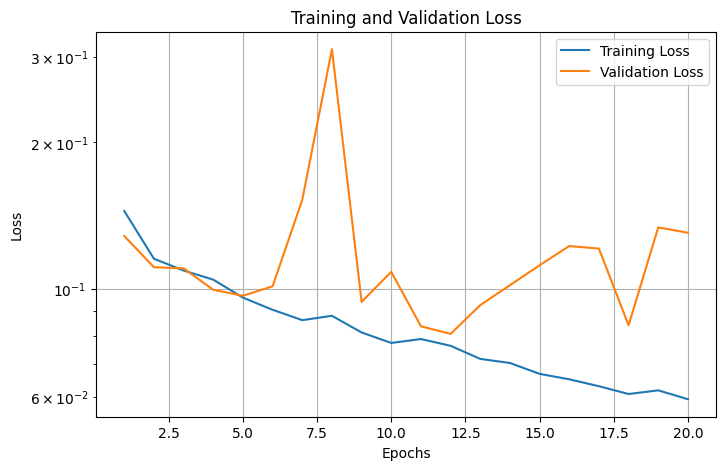

In [49]:
training_model(20, 8)

Now we have our best trained model and best weights.

# Prediction

Once we have trained Model we can now predict clean audio by loading the model and its weights. We can use any noisey audio for prediction. The next challenge here is to reconstruct the audio signal from spectrograms. We will start from the denormalization, spectromgrams to audio and in the end joining all the frames to construct the complete predicted audio.

In [50]:
def inverse_min_max_normalization(normalized_audio, min_value, max_value):
    return ((normalized_audio + 1) * (max_value - min_value)) / 2 + min_value


In [51]:
def spectrogram_to_audio(magnitude_db_list, phase_list, hop_length=63):
    reconstructed_audio = []

    for magnitude_db, phase in zip(magnitude_db_list, phase_list):
        # Convert from dB scale to amplitude
        magnitude = librosa.db_to_amplitude(magnitude_db)
        # print("magnitude.shape")
        # print(magnitude.shape)

        # Reconstruct the complex spectrogram
        D = magnitude * phase  # Element-wise multiplication

        # print("D.shape")
        # print(D.shape)
        # Inverse STFT to get back the audio signal
        audio = librosa.istft(D,n_fft=255, hop_length=hop_length)
        reconstructed_audio.append(audio)

    return np.array(reconstructed_audio)

In [16]:
from tensorflow.keras.models import model_from_json

def predict_audio(audio_dir):

# load json and create model
    json_file = open('model_unet.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model/
    loaded_model.load_weights('model_unet_best.h5')
    print("Loaded model from disk")

    # for x in os.listdir(audio_dir):
    #   y, sr = librosa.load(os.path.join(audio_dir, x), sr=sample_rate)
    #   print(y.shape)
    noisy_frame_list = split_Audios(audio_dir, frame_length, hop_length)  # It should take dir and return framelist of all the audios
    mag_n, pha_n = spectrogram(noisy_frame_list)

    min_value = np.min(mag_n)
    max_value = np.max(mag_n)

    mag_n = np.array(mag_n)
    pha_n = np.array(pha_n)
    X_input = normalize_spectrogram(mag_n)
    X_input = np.array(X_input)
    X_input = X_input.reshape(X_input.shape[0],X_input.shape[1],X_input.shape[2],1)
    print('X_input.shape')
    print(X_input.shape)
    X_pred = loaded_model.predict(X_input)
    X_pred = np.squeeze(X_pred, axis=-1)
    x_reconstructed = inverse_min_max_normalization(X_pred, min_value, max_value)
    print(x_reconstructed.shape)
    print(pha_n.shape)
    print(frame_length)
    print(hop_length_fft)

    reconstructed_audio = spectrogram_to_audio(x_reconstructed, pha_n)
    if reconstructed_audio.shape[1] < frame_length:
        # Padding the reconstructed audio if it's shorter than expected
        padding = frame_length - reconstructed_audio.shape[1]
        reconstructed_audio = np.pad(reconstructed_audio, ((0, 0), (0, padding)), mode='constant')
    nb_samples = reconstructed_audio.shape[0]
    #denoise_long = reconstructed_audio.reshape(1, nb_samples * frame_length)*10
    print(reconstructed_audio.shape)
    expected_size = nb_samples * frame_length
    actual_size = reconstructed_audio.size
    print(f"Expected size: {expected_size}, Actual size: {actual_size}")

    x = reconstructed_audio.reshape(1, nb_samples * frame_length)*10

    sf.write('audio_output_prediction.wav', x[0, :], 8000, 'PCM_24')





In [52]:
predict_audio('/content/test_samples')

Loaded model from disk
number of audios in "/content/test_samples" are 2
number of frames in "/content/test_samples" are 16
(16, 8064)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude 

<Figure size 1000x4800 with 0 Axes>

X_input.shape
(16, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(16, 128, 128)
(16, 128, 128)
8064
63
(16, 8064)
Expected size: 129024, Actual size: 129024


In [ ]:
from IPython.display import Audio

In [1]:
!pip install sounddevice


In [4]:
!pip install pipwin
!pipwin install pyaudio


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
  Created wheel for pipwin: filename=pipwin-0.5.2-py2.py3-none-any.whl size=8766 sha256=50869e24b5f708bb8bdfc07a2c38810d24accb69d6f950df5f19d2aa5eb0b51c
  Stored in directory: /root/.cache/pip/wheels/07/45/2e/51ee464b7c3407327439df34c2fc62f978a1e5084aaf23d201
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4307de780cdc23fb0368cff8bf678c4bc2d65cf882521451dc8ccf2a019b0c3e
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25983 sha256=7343ac3745057a94dd176516eb879c229b799313ec22c45df20c3c9e93a31627
  Stored in directory: /root/.cache/pip/wheels/a5/9a/30/1003e89ab4555b81840ca46d361bf184f1e6ad880cae3b62a9
Successfully b

In [53]:
from IPython.display import display, Javascript
from google.colab import output
import io
import base64
import numpy as np
import scipy.io.wavfile as wav

# JavaScript code to record audio in Colab
def record_audio_js(filename="audio.wav", duration=5):
    js_code = f"""
    const sleep = time => new Promise(resolve => setTimeout(resolve, time));
    const b2text = blob => new Promise(resolve => {{
        const reader = new FileReader();
        reader.onloadend = () => resolve(reader.result);
        reader.readAsDataURL(blob);
    }});

    async function recordAudio() {{
        const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
        const mediaRecorder = new MediaRecorder(stream);
        const audioChunks = [];
        mediaRecorder.ondataavailable = event => audioChunks.push(event.data);
        mediaRecorder.start();

        await sleep({duration * 1000});
        mediaRecorder.stop();

        await new Promise(resolve => mediaRecorder.onstop = resolve);
        const audioBlob = new Blob(audioChunks, {{ type: 'audio/wav' }});
        const base64Audio = await b2text(audioBlob);

        google.colab.kernel.invokeFunction('notebook.recorded_audio', [base64Audio], {{}})
    }}

    recordAudio();
    """
    display(Javascript(js_code))

# Callback to save recorded audio
def save_audio_callback(base64_audio):
    audio_bytes = base64.b64decode(base64_audio.split(",")[1])
    with open("recorded_audio.wav", "wb") as f:
        f.write(audio_bytes)
    print("Audio recorded and saved as 'recorded_audio.wav'")

# Register callback in Colab
output.register_callback('notebook.recorded_audio', save_audio_callback)

# Call function to record audio




In [54]:
record_audio_js(duration=5)

<IPython.core.display.Javascript object>

Audio recorded and saved as 'recorded_audio.wav'


In [57]:
import librosa
import IPython.display as ipd

# Load the recorded audio
audio, sr = librosa.load("/content/recorded_audio.wav", sr=16000)
ipd.Audio(audio, rate=sr)  # Play audio

<ipython-input-57-b499d332ccd7>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load("/content/recorded_audio.wav", sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [58]:
predict_audio('/content')

Loaded model from disk
number of audios in "/content" are 17
number of frames in "/content" are 4
(4, 8064)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)
D.shape in spec
(128, 128)
magnitude and ohase
(128, 128) (128, 128)


<ipython-input-34-699781f9fec1>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sample_rate)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Figure size 1000x1200 with 0 Axes>

X_input.shape
(4, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(4, 128, 128)
(4, 128, 128)
8064
63
(4, 8064)
Expected size: 32256, Actual size: 32256


In [59]:
audio, sr = librosa.load("/content/audio_output_prediction.wav", sr=16000)
ipd.Audio(audio, rate=sr)  # Play audio